<a href="https://colab.research.google.com/github/SuperSaid09/SuperSaid09/blob/main/surface_segmentation_using_PSPnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

as an input we have 6000 * 4000 images and masks, I reduced its resolution to 256*256 after I seperated masks by classes thus I got tensor with shape (256, 256, 24) 
and then I have two tensors: images and masks

I built model it consist light-weight architecture like Xception and PPM module as last conv block we have Conv2D with kernel-size (3,3), BN and last layer - activation function softmax. The architecture may look cumbersome, but in fact there are only 5 million parameters, for example Xception has 22 million

In [ ]:
import os
import pandas as pd
import keras 
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Input, Reshape, UpSampling2D
from tensorflow.keras.layers import  MaxPooling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path_to_zip_file = '/content/drive/MyDrive/datasets/surface_segmentation.zip'
directory_to_extract_to = '/content/surface_segmentation'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

#what all this data mean

In [ ]:
class_dict = pd.read_csv('/content/surface_segmentation/class_dict_seg.csv')
class_dict

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


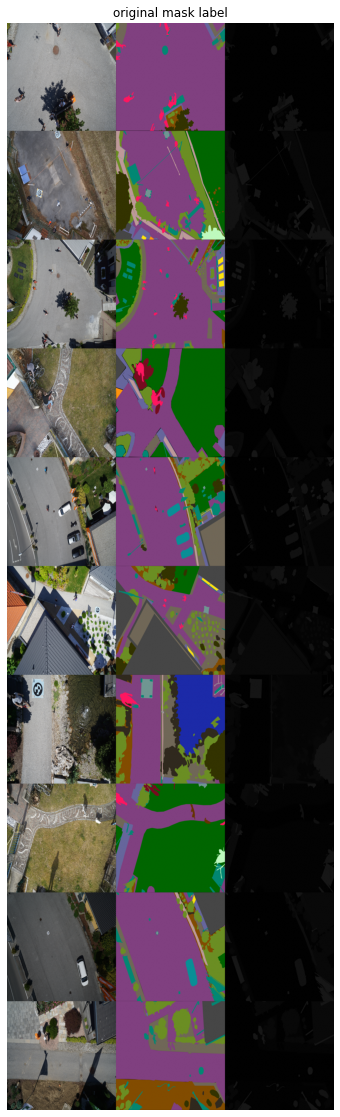

In [ ]:
def show_images(paths, count):
    original_dir, mask_dir, label_dir = paths
    original_paths = [os.path.join(original_dir, filename) 
    for filename in sorted(os.listdir(original_dir))][:count]
    mask_paths = [os.path.join(mask_dir, filename) 
    for filename in sorted(os.listdir(mask_dir))][:count]
    label_paths = [os.path.join(label_dir, filename) 
    for filename in sorted(os.listdir(label_dir))][:count]
    
    title = 'original '
    title += 'mask ' 
    title += 'label'
    unique_types = 3
    image_height = 256
    image_width = 256
    channels = 3
    
    images = np.zeros(shape = (count, 
                               image_height, 
                               image_width * unique_types, 
                               channels))
    
    for iteration in range(count):
        # path for each class of image
        current_original_path = original_paths[iteration]
        current_mask_path = mask_paths[iteration]
        current_label_path = label_paths[iteration]
        
        original = load_img(current_original_path).resize((image_height, image_width))
        original = img_to_array(original).reshape((image_height, image_width, 3))
        
        mask = load_img(current_mask_path).resize((image_height, image_width))
        mask = img_to_array(mask).reshape((image_height, image_width, 3))

        label = load_img(current_label_path).resize((image_height, image_width))
        label = img_to_array(label).reshape((image_height, image_width, 3))
        
        h_stack = np.hstack([original, mask, label])
        images[iteration] = h_stack
    
    images = np.concatenate(images) / 255
    plt.figure(figsize = (20,20))
    plt.title(title)
    plt.axis('off')
    plt.imshow(images)

images_path = '/content/surface_segmentation/dataset/semantic_drone_dataset/original_images'
masks_path = '/content/surface_segmentation/RGB_color_image_masks/RGB_color_image_masks'
labels_path = '/content/surface_segmentation/dataset/semantic_drone_dataset/label_images_semantic'

paths = [images_path, masks_path, labels_path]
count = 10
show_images(paths = paths, count = count)

# model architecture

In [ ]:
def sep_bn_act(inputs, filters, index, use_maxpool):
    block = Activation('relu')(inputs)
    block = SeparableConv2D(filters = filters, 
                            kernel_size = 3, 
                            padding ='same', 
                            name = f'block{index}_sepconv_1', )(block)
    block = BatchNormalization(name = f'block{index}_sepconv1_BN')(block)
    block = Activation('relu', name = f'block{index}_sepconv1_act')(block)
    
    block = SeparableConv2D(filters = filters, 
                            kernel_size = 3, 
                            padding ='same', 
                            name = f'block{index}_sepconv_2')(block)
    
    block = BatchNormalization(name = f'block{index}_sepconv2_BN')(block)
    
#     if use_maxpool:
#         block = MaxPooling2D(pool_size = 2)(block)
#     else:
    block = Activation('relu')(block)
        
        
    return block


def residual(inputs, filters, index, strides, padding = 'same'):
    res_conv = Conv2D(filters = filters, 
                      kernel_size = 3, 
                      strides = strides,
                      padding = padding,
                      name = f'residual_conv_{index}')(inputs)
    res_conv = BatchNormalization(name = f'residual_BN_{index}')(res_conv)
    
    return res_conv

In [ ]:
def light_xception(inputs, mode = 'layers'):

    '''
    this function create like-xception model
    with 5 millions params instead 22 millons 
    in original

    Arguments:
        inputs(tensor): outputs of previuos layers or input data
        mode(str): parameter of this model
    
    Returns: 
        light-weight xception model
    '''
    strides = 1
    image_height = inputs.shape[1]
    image_width = inputs.shape[2] 
    width_condition = np.sqrt(image_width) == int(np.sqrt(image_width))
    height_condition = np.sqrt(image_height) == int(np.sqrt(image_height))
    assertion = 'both sides of image must be 2 **n and greater than 2 **3'
    # assert width_condition, assertion
    # assert height_condition, assertion
    
    index = 1
    
    #       input block           
    ################################################################
    if mode == 'model':
        inputs = Input(shape = input_shape, name = 'input_layer')
    
    # block 1
    ################################################################
    filters = 64
    block_0 = sep_bn_act(inputs = inputs, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    ################################################################
    
    index +=1
    filters = 128
    
    #separable
    block_1 = sep_bn_act(inputs = block_0, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_1 = residual(inputs = block_0, 
                          filters = filters,
                          index=index, 
                          strides = strides)
    
    #    add block    
    add_1 = Add(name = f'add_{index}')([block_1, res_conv_1])
    
    
    #################################################################
    
    index +=1
    filters = 256
    
    #separable
    block_2 = sep_bn_act(inputs = add_1, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_2 = residual(inputs = add_1, 
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_2 = Add(name = f'add_{index}')([block_2, res_conv_2])
    
    #################################################################
    
    index +=1
    filters = 512
    
    #separable
    block_3 = sep_bn_act(inputs = add_1, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    
    #    residual block      
    res_conv_3 = residual(inputs = add_1,
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_3 = Add(name = f'add_{index}')([block_3, res_conv_3])
    
    #################################################################
    
    index +=1
    filters = 512
    
    #separable
    block_4 = sep_bn_act(inputs = add_3, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    index +=1
    block_4 = sep_bn_act(inputs = block_4, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    #    add block    
    add_4 = Add(name = f'add_{index}')([block_4, add_3])
    
    #################################################################
    

    index +=1
    filters = 512
    
    #separable
    block_5 = sep_bn_act(inputs = add_4, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = True)
    #    residual block      
    res_conv_5 = residual(inputs = add_4, 
                          filters = filters, 
                          index=index, 
                          strides = strides)
    #    add block    
    add_5 = Add(name = f'add_{index}')([block_5, res_conv_5])
    
    ##################################################################
    
    index +=1
    filters = 128
    
    #separable
    outputs = sep_bn_act(inputs = add_5, 
                         filters = filters, 
                         index = index, 
                         use_maxpool = False)
    
    result = Model(inputs = inputs, outputs = outputs)
    
    if mode == 'layers':
        result = outputs
    
    return result

input_shape = (128, 128, 3)
#fake data for building the model
example_data = np.zeros(shape = (32,) + input_shape)

light_xception_model = light_xception(inputs = example_data, mode = 'model')

In [ ]:
xception_model = Xception()

91889664/91884032 [==============================] - 0s 0us/step


In [ ]:
light_count = light_xception_model.count_params()
full_count = xception_model.count_params()
print('light: ', light_count)
print('full :       ', full_count)
print('difference:     ', round(full_count / light_count, 1))

light:  5222235
full :        22910480
difference:      4.4


![image.png](attachment:95b2d0b4-98b2-4dba-99c4-f385384aee1d.png)

![image.png](attachment:3f7c746e-3391-46df-86a8-6953484a7833.png)

In [ ]:
def PPM(inputs):
    '''
    PPM - Pyramyd Pooling Module
    this function just create PP module
    '''
    
    # parameters
    filters = 128
    kernel_size = (1, 1)
    interpolation = 'bilinear'
    
    #base
    base = light_xception(inputs = inputs, mode = 'layers')
    
    #red
    red = GlobalAveragePooling2D(name = 'red_glob_av_pooling')(base)
    red = Reshape(target_shape = (1, 1,128))(red)
    red = Conv2D(filters = filters, 
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_1_1x1')(red)
    red = BatchNormalization(name = 'red_BN_1')(red)
    red = Conv2D(filters = filters * 2,
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_2_1x1')(red)
    red = BatchNormalization(name = 'red_BN_2')(red)
    red = Conv2D(filters = filters, 
                 kernel_size = kernel_size, 
                 padding = 'same', name = 'red_3_1x1')(red)
    red = BatchNormalization(name = 'red_BN_3')(red)
    red = UpSampling2D(size = 128, 
                       interpolation = interpolation, 
                       name = 'red_upsampling')(red)
    
    #blue
    blue = AveragePooling2D(pool_size = 2, 
                            name = 'blue_av_pooling')(base)
    blue = Conv2D(filters = filters, 
                  kernel_size = kernel_size, 
                  padding = 'same', 
                  name = 'blue_1_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_1')(blue)
    blue = Conv2D(filters = filters * 2, 
                  kernel_size = kernel_size, 
                  padding = 'same', name = 'blue_2_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_2')(blue)
    blue = Conv2D(filters = filters, 
                  kernel_size = kernel_size, 
                  padding = 'same', name = 'blue_3_1x1')(blue)
    blue = BatchNormalization(name = 'blue_BN_3')(blue)
    blue = UpSampling2D(size = 2, interpolation = interpolation, 
                        name = 'blue_upsampling')(blue)
    
    #green
    green = AveragePooling2D(pool_size = 4, 
                             name = 'green_av_pooliing')(base)
    green = Conv2D(filters = filters, 
                   kernel_size = kernel_size, 
                   padding = 'same', name = 'green_1_1x1')(green)
    green = BatchNormalization(name = 'green_BN_1')(green)
    green = Conv2D(filters = filters * 2, 
                   kernel_size = 
                   kernel_size, padding = 'same', 
                   name = 'green_2_1x1')(green)
    green = BatchNormalization(name = 'green_BN_2')(green)
    green = Conv2D(filters = filters, 
                   kernel_size = kernel_size, 
                   padding = 'same', name = 'green_3_1x1')(green)
    green = BatchNormalization(name = 'green_BN_3')(green)
    green = UpSampling2D(size = 4, name = 'green_upsampling')(green)
    
    #yellow
    yellow = AveragePooling2D(pool_size = 8, 
                              name = 'yellow_av_pooling')(base)
    yellow = Conv2D(filters = filters, 
                    kernel_size = kernel_size, padding = 'same', 
                    name = 'yellow_1_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_1')(yellow)
    yellow = Conv2D(filters = filters * 2, 
                    kernel_size = kernel_size, 
                    padding = 'same', name = 'yellow_2_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_2')(yellow)
    yellow = Conv2D(filters = filters, 
                    kernel_size = kernel_size, 
                    padding = 'same', name = 'yellow_3_1x1')(yellow)
    yellow = BatchNormalization(name = 'yellow_BN_3')(yellow)
    yellow = UpSampling2D(size = 8, name = 'yellow_upsampling')(yellow)
    
    result = Concatenate(
        name = 'concatenate_layer')([base, red, blue, green, yellow])
    
    return result
    

    
def PSPnet_last_conv(inputs, classes):
    ppm_outputs = PPM(inputs)
    
    x = Conv2D(filters = classes, 
               kernel_size = 3, 
               padding = 'same', 
               name = 'last_module_conv')(ppm_outputs)
    x = BatchNormalization(name = 'last_module_BN')(x)
    x = Activation('softmax')(x)
    
    return x



def build_PSPnet():
    inputs = Input(shape = input_shape, name = 'input')
    outputs = PSPnet_last_conv(inputs, classes = 24)

    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.metrics import MeanIoU

    pspnet = Model(inputs = inputs, outputs = outputs, name = 'PSPnet')
    pspnet.compile(loss = 'categorical_crossentropy', 
                   metrics = ['accuracy', MeanIoU(num_classes = 24)], 
                   optimizer = Adam(lr = 0.01))
    return pspnet

pspnet = build_PSPnet()

In [ ]:
pspnet.count_params()

5581395

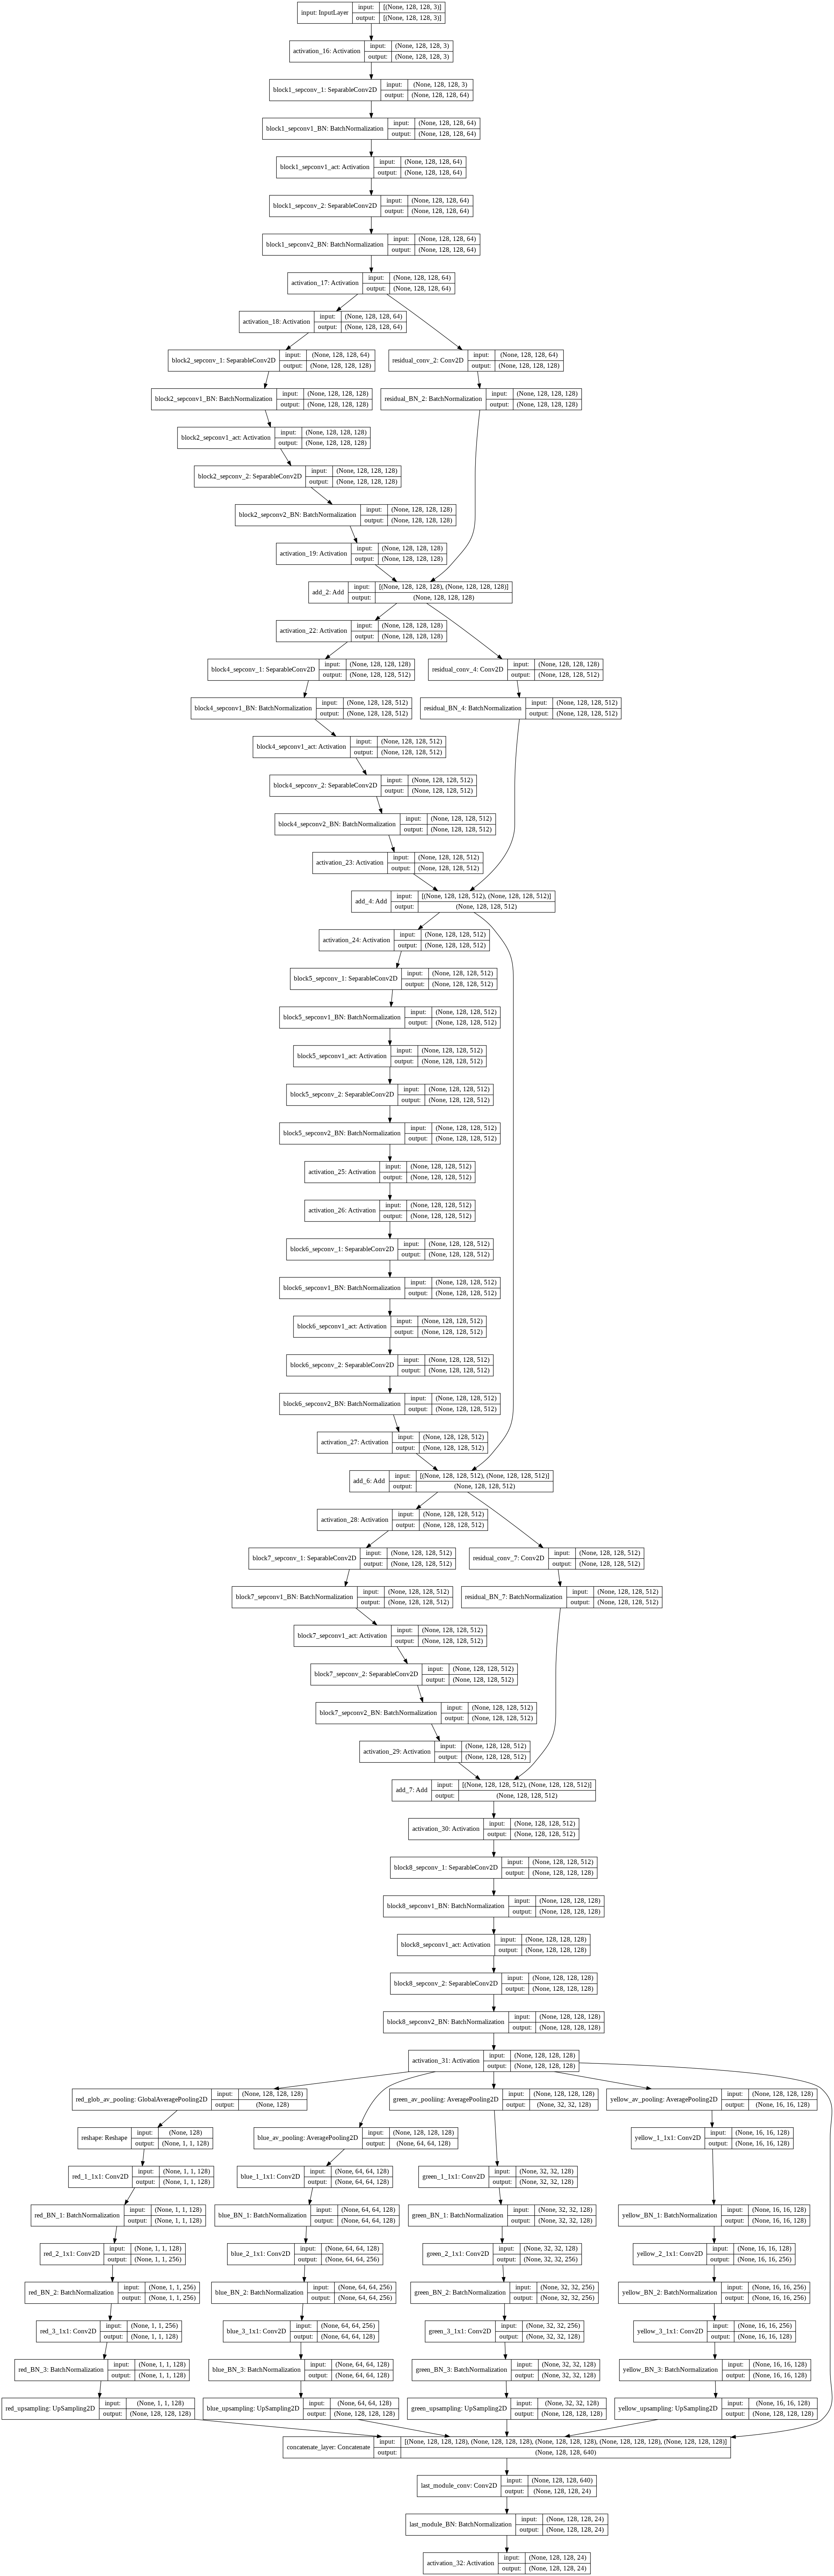

In [ ]:
plot_model(pspnet, show_shapes = True)

# let's separate masks by classes

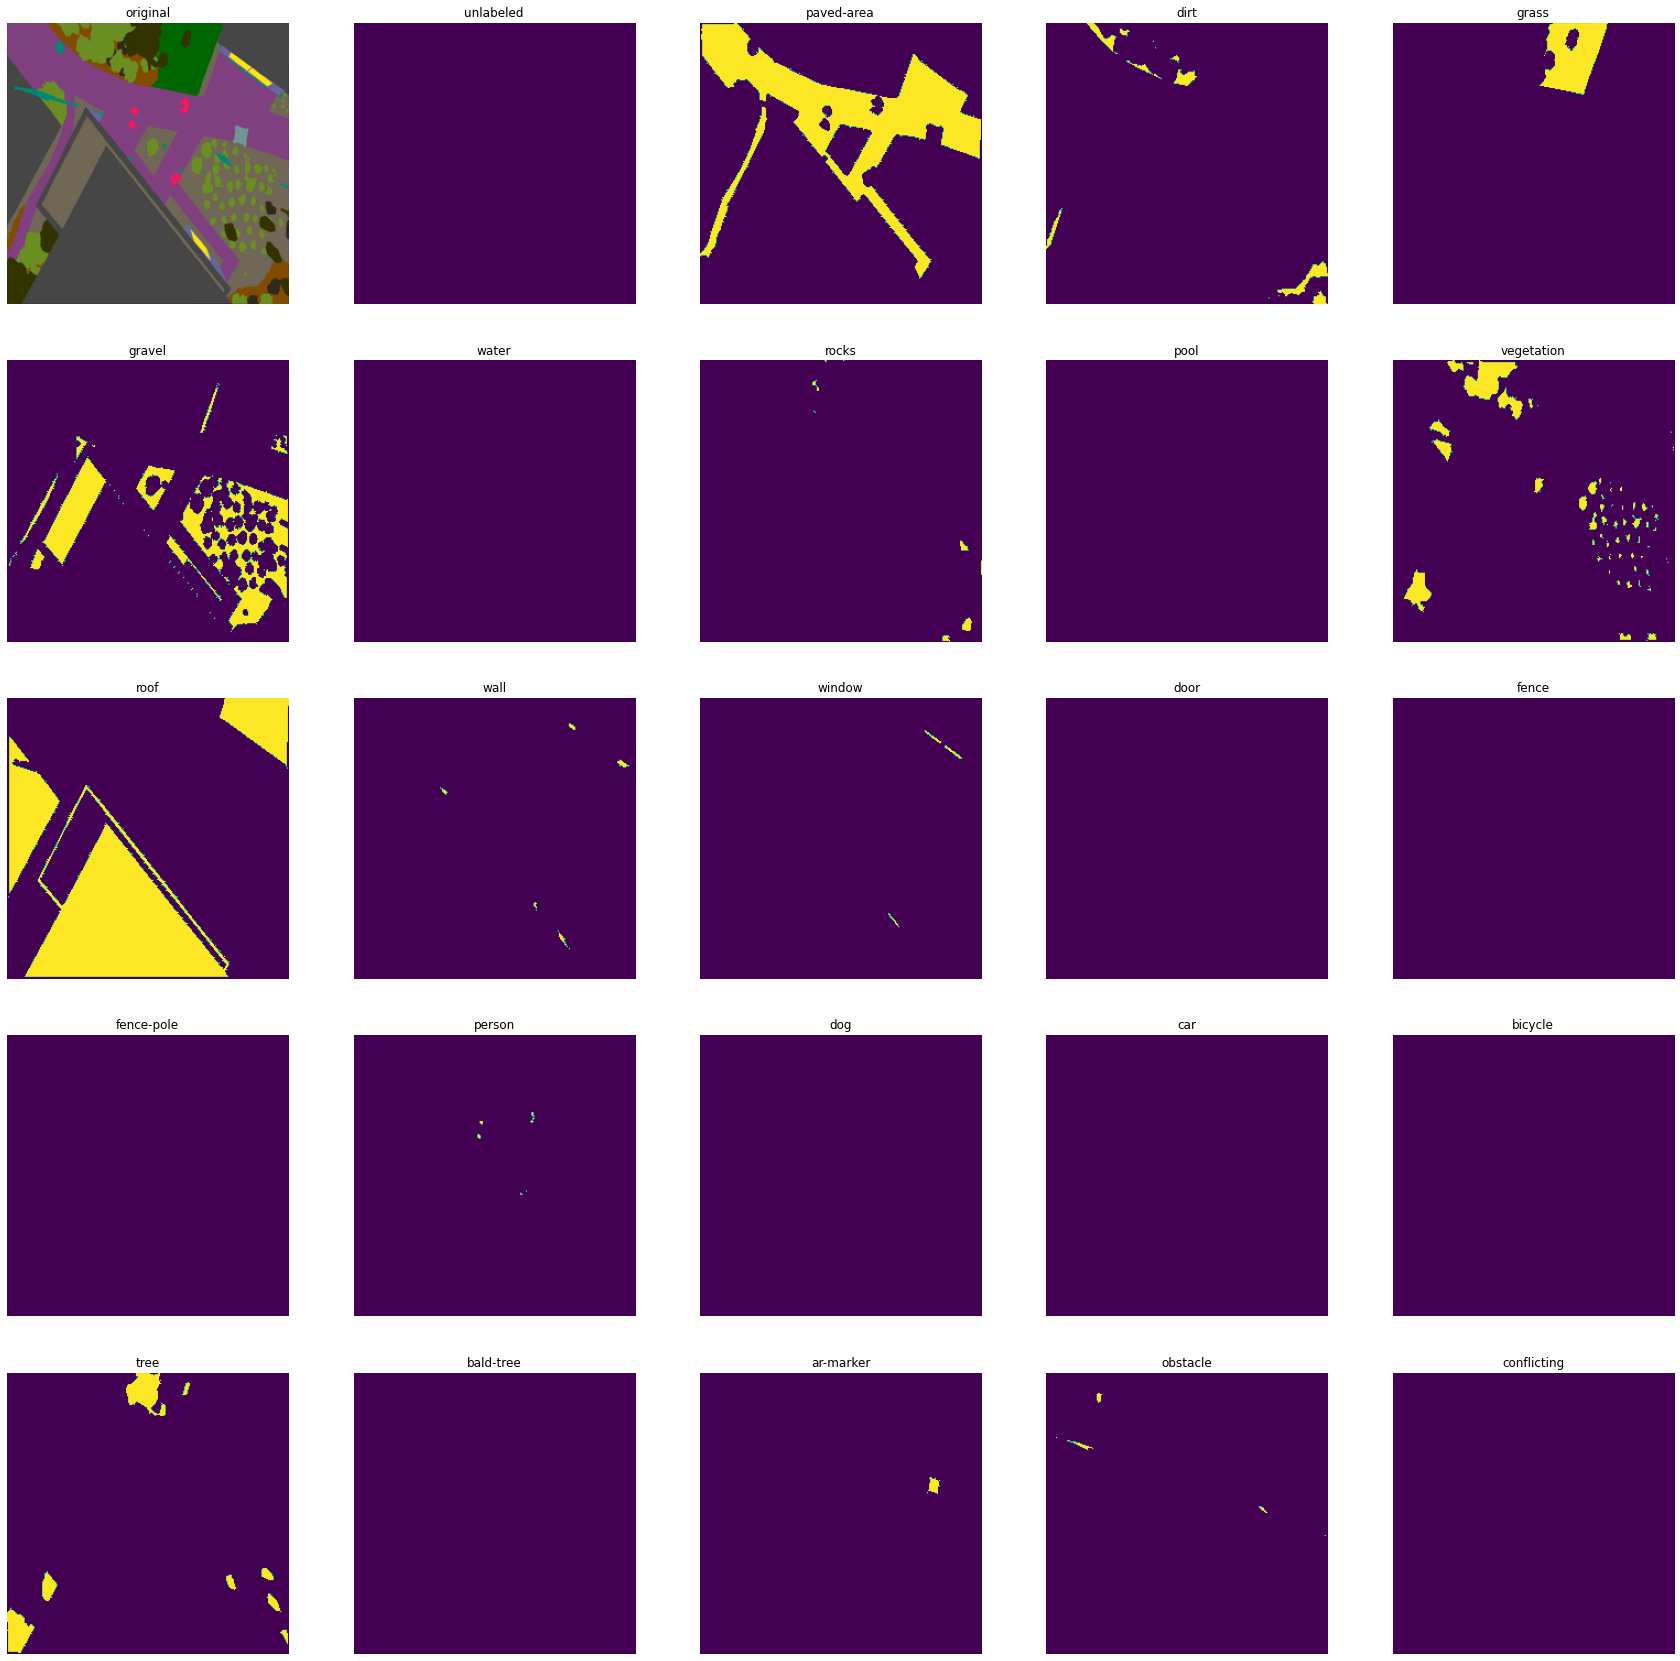

In [ ]:
num_classes = len(class_dict)
image_src = '/content/surface_segmentation/RGB_color_image_masks/RGB_color_image_masks/005.png'

mask_example = load_img(image_src)
mask_example = mask_example.resize((256, 256))
mask_example = img_to_array(mask_example).astype('uint8')
separate_mask = np.zeros(shape = (1, 256, 256, num_classes))

plt.figure(figsize = (30, 30))
plt.subplot(5,5,1)
plt.axis('off')
plt.title('original')
plt.imshow(mask_example)

for iteration in range(num_classes):
    current_feature_name = list(class_dict.iloc[iteration])[0]
    colors = tuple(class_dict.iloc[iteration][1:].map(int))
    separate_mask_class = cv2.inRange(mask_example, colors, colors)
    separate_mask[0, :, :, iteration] = separate_mask_class / 255
    
    
    
    plt.subplot(5, 5, iteration + 2)
    plt.axis('off')
    plt.title(current_feature_name)
    plt.imshow(separate_mask_class)


In [ ]:
def separate_image(mask_src, num_classes):
    '''
    this function takes original mask and convert it into 
    24 channels tensor, each channel consist binary image 
    
    Arguments:
        mask_src(string): path to original mask
        num_classes(int): number of unique classes in mask
    '''
    
    channels = 3
    image_size = 128
    current_mask = load_img(mask_src)
    current_mask = img_to_array(current_mask).astype('uint8')
    separated_mask = np.zeros(shape = (image_size, image_size, num_classes))
    
    for iteration in range(num_classes):
        current_feature_name = list(class_dict.iloc[iteration])[0]
        colors = tuple(class_dict.iloc[iteration][1:].map(int))
        separated_mask_class = cv2.inRange(current_mask, colors, colors)
        separated_mask[:, :, iteration] = separated_mask_class
        
    return separated_mask

num_classes = len(class_dict)
image_src = '/content/surface_segmentation/RGB_color_image_masks/RGB_color_image_masks/000.png'

In [ ]:
def reduce_dim(source_dir, target_size):
    '''
    this function takes images from one 
    directory reduce their size to target_size
    and write them into target directory

    Arguments:
        source_dir(str): path to directory with images
        target_size(tuple): image will be resized to this size

    returns:
        target_dir(str): directory with resized images
    '''
    working_directory = '/content'
    dir_name = source_dir.split('/')[-1]
    target_dir = os.path.join(working_directory, dir_name)
    print(target_dir)
    
    if os.path.isdir(target_dir) == False:
        os.mkdir(target_dir)
        
    original_filenames = [os.path.join(source_dir, filename) for filename in sorted(os.listdir(source_dir))]
    target_filenames = [os.path.join(target_dir, filename) for filename in sorted(os.listdir(source_dir))]
    
    for index in range(len(original_filenames)):
        current_orig_filename = original_filenames[index]
        current_target_filename = target_filenames[index]
        
        image = cv2.imread(current_orig_filename)
        image = cv2.resize(image, target_size)

        cv2.imwrite(img = image, filename = current_target_filename)
    
    return target_dir

source_dir = '/content/surface_segmentation/dataset/semantic_drone_dataset/original_images'
masks_dir = '/content/surface_segmentation/RGB_color_image_masks/RGB_color_image_masks'
target_size = (128, 128)

images_dir = reduce_dim(source_dir = source_dir, target_size = target_size)
masks_dir = reduce_dim(source_dir = masks_dir, target_size = target_size)


/content/original_images
/content/RGB_color_image_masks


In [ ]:
# if u already reduced dim
images_dir = '/content/original_images'
masks_dir = '/content/RGB_color_image_masks'

In [ ]:
len(os.listdir('/content/original_images'))

400

In [ ]:
def make_batch(batch_size, masks_path, images_path):
    
    '''
    this function convert images from directory to tensors. 
    images to (img_size, img_size, 3) masks to (img_size, img_size, 24)

    Arguments:
        batch_size(int): number of images in tensor
        masks_path(str): path to directory with masks
        images_path(str): path to directory with images
    Returns:
        two tensors: with masks and with images
    '''

    condition = batch_size <= len(os.listdir(masks_path))
    assertion = 'batch size have not be greater'
    assertion += ' than all lenth of all directory'
    assert condition, assertion 
    images_paths = [os.path.join(images_path, filename) for filename 
                    in sorted(os.listdir(images_path))[:batch_size]]
    
    masks_paths = [os.path.join(masks_path, filename) for filename 
                    in sorted(os.listdir(masks_path))[:batch_size]]
    image_size = 128
    channels = 3
    num_classes = 24
    
  
    train_images_paths = images_paths
    train_masks_paths = masks_paths
    
    train_images = np.zeros(shape = (batch_size, 
                                     image_size, 
                                     image_size, 
                                     channels))
    train_masks = np.zeros(shape = (batch_size, 
                                    image_size, 
                                    image_size, 
                                    num_classes))
    
    for index in range(batch_size):
        # print(f"{'-' * 5}train_set:_{index + 1}{'-' * 5}")
        current_image_path = train_images_paths[index]
        current_mask_path = train_masks_paths[index]
        image = img_to_array(load_img(current_image_path)) / 255
        image = image.astype('float32') 
        mask = separate_image(current_mask_path, num_classes) / 255
        mask = mask.astype('float32') 
        
        train_images[index] = image
        train_masks[index] = mask
   
   
        
    data = [train_images.astype(np.float32), 
            train_masks.astype(np.float32)]
    
    return data

In [ ]:
train_images, train_masks = make_batch(batch_size = 400, 
                                       masks_path = masks_dir, 
                                       images_path = images_dir)

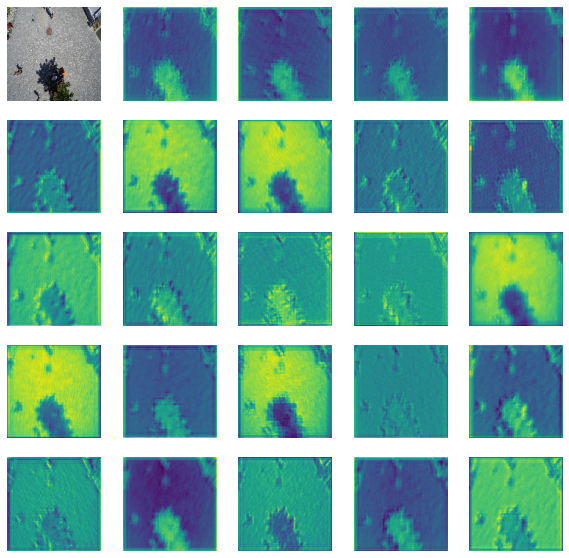

In [ ]:
pspnet = build_PSPnet()

def plot_masks(img, model, iteration = -1):
    '''
    this function shows predicted masks for image

    Arguments:
        img(tensor): image for prediction
        model(tf.model): neural network
        iteration(int): current iteration of training
    '''
    img_for_pred = img.reshape((1, ) + img.shape)
    prediction = pspnet.predict(img_for_pred)
    mask = prediction.reshape(128, 128, 24)

    epoch = (iteration + 1) * 10
    num_classes = len(class_dict)
    plt.figure(figsize = (10, 10))
    plt.subplot(5,5,1)
    plt.axis('off')
    plt.imshow(img)
    for iteration in range(num_classes):
        plt.subplot(5,5,iteration + 2)
        plt.axis('off')
        plt.imshow(mask[:,:,iteration])
    
    plt.savefig(fname = f'prediction_{epoch}.png')

plot_masks(train_images[0], model = pspnet)

In [ ]:
train_images.dtype

dtype('float32')

# train model

In [ ]:
!nvidia-smi

Mon May 24 12:54:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  14828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train_model(iterations, weights_path = None):
    '''
    training function
    
    iterations:
        iterations(int): number of iterations, 
        each consist 10 epochs of training

        weights_path(str): path to weights for model
        if this path contain already builded weights
        model will load it 
    returns:
        trained model
    '''
    pspnet = build_PSPnet()
    if os.path.isfile(weights_path):
        pspnet.load_weights(weights_path)
    callbacks = [ReduceLROnPlateau(monitor = 'loss',
                                factor = 0.2, 
                                min_delta = 0.00001,
                                patience = 4),
                ModelCheckpoint(filepath = weights_path,
                                monitor = 'loss',
                                save_best_only = True)]

    test_image = train_images[5]

    for iteration in range(iterations):
        pspnet.fit(x = train_images, 
                y = train_masks,
                batch_size = 8,
                epochs = 10,
                verbose = 1,
                callbacks = callbacks)

        plot_masks(img = test_image, 
                   model = pspnet, 
                   iteration = iteration)

    return pspnet

weights_path = '/content/drive/MyDrive/pspnet_best_weights.h5'
pspnet = train_model(iterations = 2, weights_path = weights_path )

In [ ]:
def cvt_masks_to_mask(masks):
    '''
    this function convert input tensor 
    with shape (image_size, image_size, num_classes)
    to (image_size, image_size, 3)

    Arguments:
        masks(tensor): tensor with shape == (128, 128, num_classes)
    '''
    image_shape = (128, 128, 3)
    result = np.zeros(shape = image_shape)
    for iteration in range(num_classes):
        current_result = np.zeros(shape = image_shape)
        current_mask = masks[:,:,iteration]
        current_feature_name = list(class_dict.iloc[iteration])[0]
        colors = tuple(class_dict.iloc[iteration][1:].map(int))

        current_result[:,:,0] = current_mask
        current_result[:,:,1] = current_mask
        current_result[:,:,2] = current_mask 

        current_result *= colors

        result += current_result
    
    return result
        

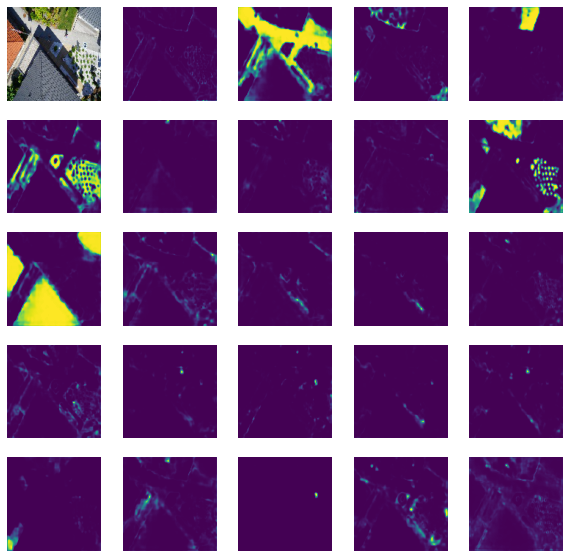

In [ ]:
def show_pred_24masks():
    '''
    this function shows us mask for each class
    '''
    pspnet.load_weights('/content/drive/MyDrive/pspnet_best_weights.h5')
    test_image = train_images[5]
    plot_masks(img = test_image, 
               model = pspnet, 
               iteration = iteration)
    img_for_pred = test_image.reshape((1, ) + test_image.shape)
    prediction = pspnet.predict(img_for_pred)
    masks = prediction.reshape(128, 128, 24)
    mask = cvt_masks_to_mask(masks) / 255

    return mask
mask = show_pred_24masks()

|     original     |  truth_mask      |truth_segmentated     |pred_mask      | pred_segmentated     


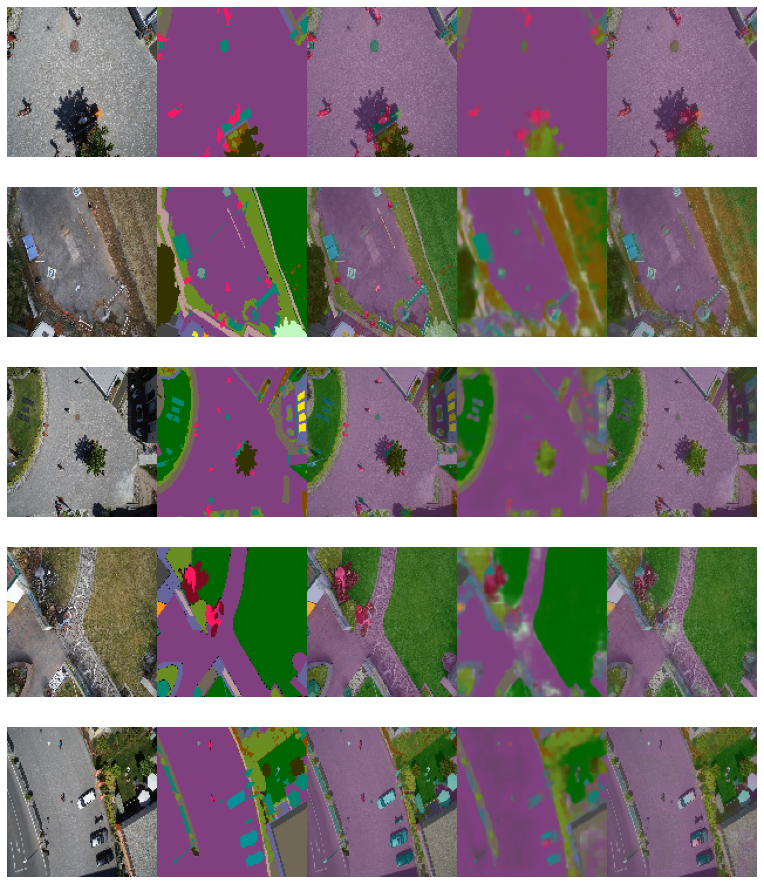

In [ ]:
def show_preds(num_examples = 5):
    '''
    this function shows us predicted masks
    from pspnet model

    Arguments:
        num_examples(int): number examples of predictions
    '''
    pspnet.load_weights('/content/drive/MyDrive/pspnet_best_weights.h5')

    rgb_path = '/content/RGB_color_image_masks'
    masks_paths = [os.path.join(rgb_path, filename) 
    for filename in sorted(os.listdir(rgb_path))]

    space = ' ' * 5
    suptitle = f'|{space}original{space}|  truth_mask {space}|'
    suptitle += f'truth_segmentated{space}|'
    suptitle += f'pred_mask {space}| pred_segmentated{space}'
    plt.figure(figsize=(16, 16))
    print(suptitle)

    for index in range(num_examples):
        test_image = train_images[index]
        img_for_pred = test_image.reshape((1, ) + test_image.shape)
        prediction = pspnet.predict(img_for_pred)

        ground_truth_mask = img_to_array(
            load_img(masks_paths[index])) / 255

        masks = prediction.reshape(128, 128, 24)
        mask = cvt_masks_to_mask(masks) / 255
        segmentated_image = (mask + test_image) / 2
        truth_segmentated_img = (ground_truth_mask + test_image) / 2
        hstack = np.hstack([test_image, ground_truth_mask, 
                            truth_segmentated_img, 
                            mask, segmentated_image])
        
        plt.subplot(num_examples, 1, index + 1)
        plt.axis('off')
        plt.imshow(hstack)

hstack = show_preds()

In [ ]:
pspnet.evaluate(train_images[:100], train_masks[:100])

4/4 [==============================] - 6s 1s/step - loss: 0.5736 - accuracy: 0.8213 - mean_io_u_11: 0.4793


[0.5735740065574646, 0.8212518095970154, 0.4792579114437103]